# Model

## Import libraries

In [24]:
# Fix randomness and hide warnings
SEED = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(SEED)

import logging

import random
random.seed(SEED)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.utils import plot_model
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import seaborn as sns
import os
import shutil
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Set Platform

In [25]:
def setPlatform(platform) -> tuple[str]:
    if platform == "Colab":
        from google.colab import drive
        drive.mount('/gdrive')
        %cd /gdrive/My Drive/AN2DL challenges/challenge2
        return "categories.npy", "training_data.npy", "valid_periods.npy", "logfiles/"
    elif platform == "Kaggle":
        try:
            # Output directory cleaning
            shutil.rmtree("/kaggle/working")
        except:
            print("Output directory is empty.")
        return "/kaggle/input/dataset/categories.npy", "/kaggle/input/dataset/training_data.npy", "/kaggle/input/dataset/valid_periods.npy", "/kaggle/working/logfiles/"
    else:
        raise Exception("Error: platform should be Colab or Kaggle.")

# platform : "Colab" | "Kaggle"
PLATFORM = "Kaggle"
CATEGORIES_PATH, DATASET_PATH, VALID_PERIODS_PATH, LOGFILE_PATH = setPlatform(PLATFORM)

Output directory is empty.


In [26]:
if not os.path.exists(LOGFILE_PATH):
    os.makedirs(LOGFILE_PATH)
else:
    try:
        shutil.rmtree(LOGFILE_PATH)
        os.makedirs(LOGFILE_PATH)
    except OSError as e:
        f"The folder {LOGFILE_PATH} does not exist."

### Plotter

In [27]:
def plotter(to_plot, labels, axvline=None, title=None, fill_between=None) -> None:
    plt.figure(figsize=(17,4))
    for i in range(len(to_plot)):
        plt.plot(to_plot[i][0], to_plot[i][1], label=labels[i])
    if axvline:
        plt.axvline(x=axvline, label=labels[-1], alpha=.3, ls='--', color='#5a9aa5')
    if fill_between:
        plt.fill_between(fill_between[0], fill_between[1], fill_between[2], color='orange', alpha=.3)
    if title:
        plt.title(title)
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

## Load and process the dataset

In [28]:
dataset_padded = pd.DataFrame(np.load(DATASET_PATH, allow_pickle=True))
categories = pd.DataFrame(np.load(CATEGORIES_PATH, allow_pickle=True))
valid_periods = pd.DataFrame(np.load(VALID_PERIODS_PATH, allow_pickle=True))

dataset_padded = dataset_padded.astype(np.float32)

print(f'Padded Dataset shape: {dataset_padded.shape}')
print(f'Categories shape: {categories.shape}')
print(f'valid_periods shape: {valid_periods.shape}')

Padded Dataset shape: (48000, 2776)
Categories shape: (48000, 1)
valid_periods shape: (48000, 2)


### Inspect categories

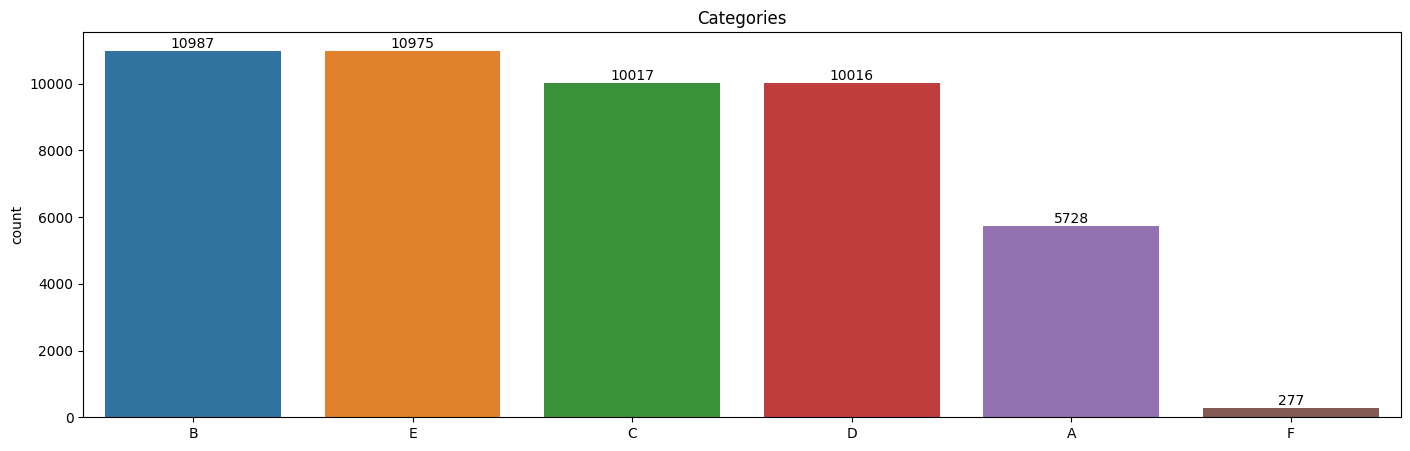

In [29]:
plt.figure(figsize=(17,5))
ax = sns.countplot(x = 0, data = categories, order = categories[0].value_counts().index)
ax.bar_label(container = ax.containers[0], labels=categories[0].value_counts())
plt.xlabel(None)
plt.title('Categories')
plt.show()

### Inspect time series length for each category

In [30]:
count_lengths = pd.DataFrame(columns=categories[0].sort_values().unique())
# count number of time series having length >= n
for n in [70, 180, 200, 300, 400]:
    tmp = []
    for cat in categories[0].sort_values().unique():
        length = (valid_periods[1]-valid_periods[0]).loc[dataset_padded.loc[categories[0] == cat].index]
        tmp.append(length[length >= n].shape[0])
    count_lengths.loc[n] = tmp

count_lengths

,A,B,C,D,E,F
70,5689,7400,8276,7373,6229,214
180,4651,4559,5457,5837,4337,120
200,4088,3671,5282,5633,4263,120
300,1452,842,1490,2304,655,47
400,1019,429,842,884,233,29


### Category-wise splitting

In [31]:
def split_by_categories(dataset) -> list[pd.DataFrame]:
    dataset_categories = []
    for cat in categories[0].sort_values().unique():
        dataset_categories.append(dataset.loc[categories[0] == cat])
    return dataset_categories

### QuantileTransformer

In [32]:
def normalization(dataset) -> tuple[QuantileTransformer, np.ndarray]:
    # Compute the quantiles used for transforming
    scaler = QuantileTransformer().fit(np.expand_dims(dataset, axis=1))
    # Transformation of the data
    scaled = np.squeeze(scaler.transform(np.expand_dims(dataset, axis=1)), axis=1)
    return scaler, scaled

### Inspect time series ACF and PACF for each category

In [33]:
def check_stationarity(series) -> None:
    result = adfuller(series)

    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print('Critical Values:')
    for key, value in result[4].items():
        print(f"\t {key}: {value}")

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

def plot_acf_pacf(series, lag_acf, lag_pacf, T) -> None:
    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    plot_acf(series, lags=lag_acf, ax=ax[0])
    plot_pacf(series, lags=lag_pacf, ax=ax[1], method='ols')
    for i in range(2):
        ax[i].axvline(x=T, color='r', linestyle='--')
        ax[i].set_xlim([-0.5, lag_acf+0.5])
        ax[i].set_ylim([-1.1, 1.1])
    plt.tight_layout()
    plt.show()

#### Category A

Category A
ADF Statistic: -2.895395574940876
p-value: 0.045886055373871665
Critical Values:
	 1%: -3.473542528196209
	 5%: -2.880497674144038
	 10%: -2.576878053634677
Stationary


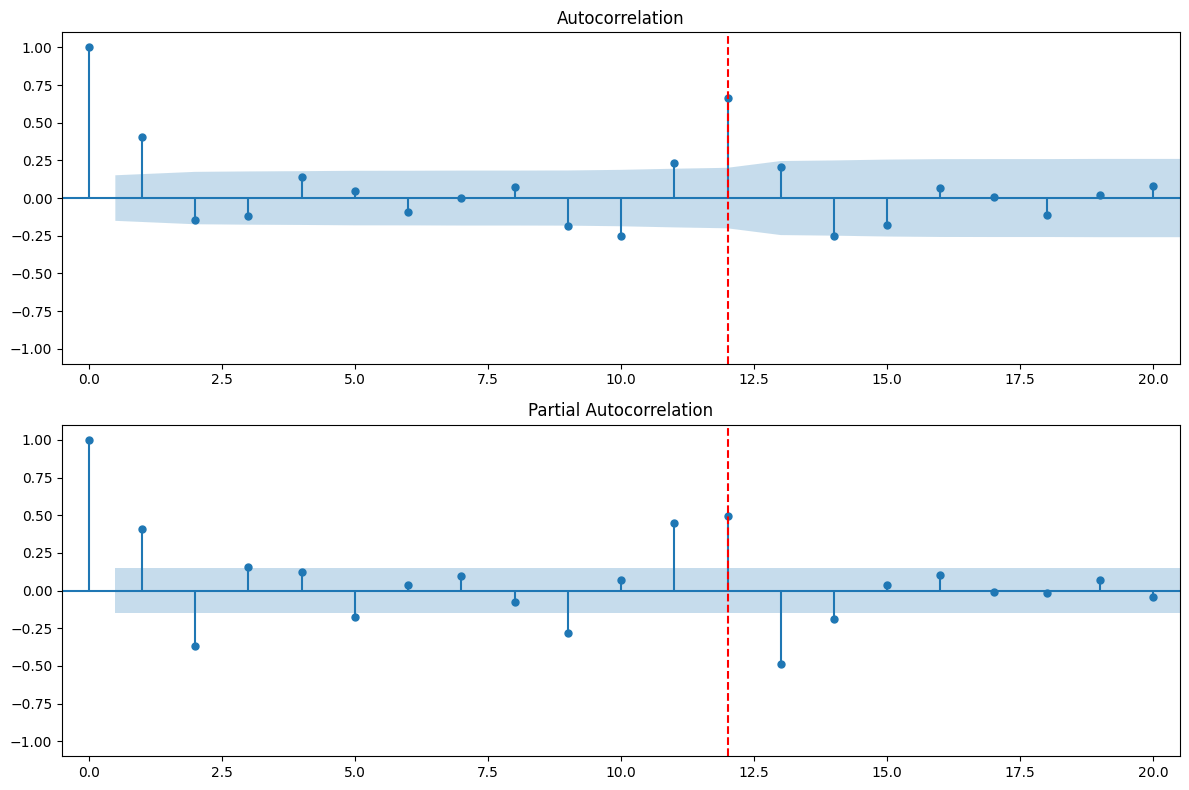

In [34]:
index = 200
dataset_splitted = split_by_categories(dataset_padded)

CAT_RUNNING = 0
series = dataset_splitted[CAT_RUNNING].iloc[index]
series = series[valid_periods.loc[series.name, 0]:valid_periods.loc[series.name, 1]]

print("Category A")
check_stationarity(series)
plot_acf_pacf(series, 20, 20, 12)

#### Category B

Category B
ADF Statistic: -2.895395574940876
p-value: 0.045886055373871665
Critical Values:
	 1%: -3.473542528196209
	 5%: -2.880497674144038
	 10%: -2.576878053634677
Stationary


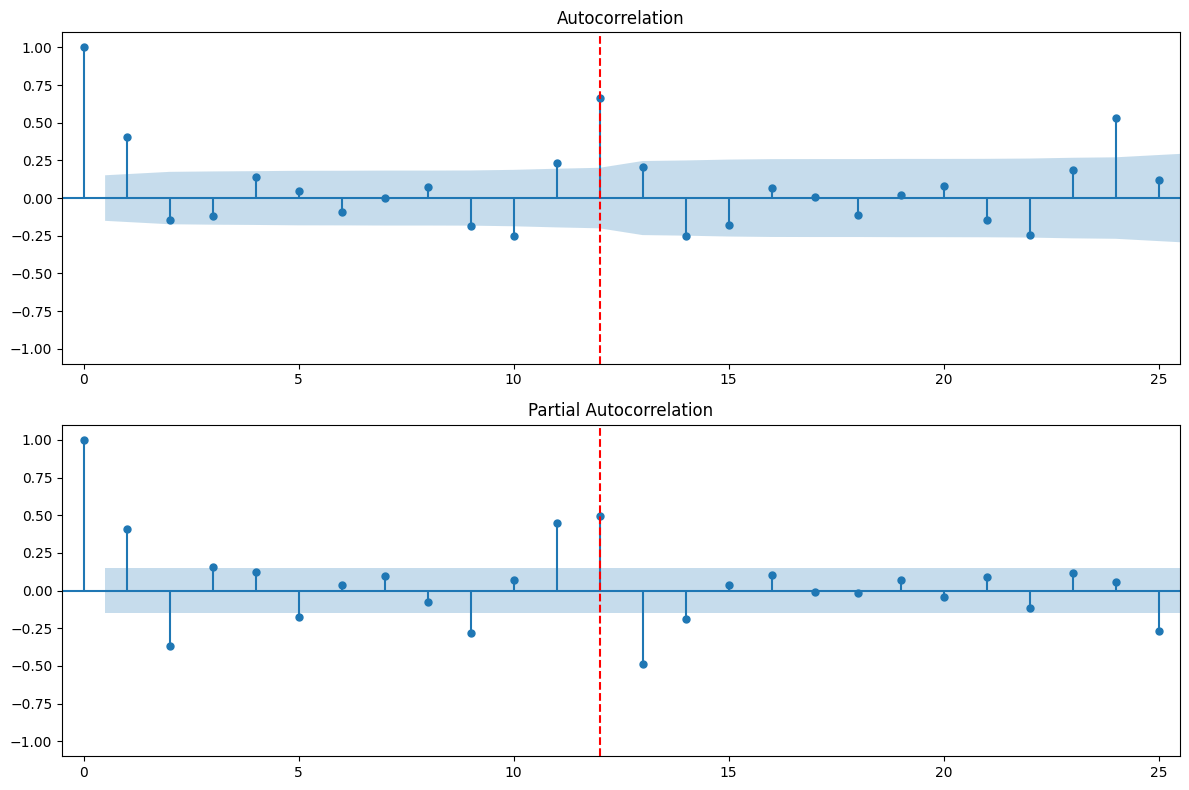

In [35]:
index = 200
dataset_splitted = split_by_categories(dataset_padded)

CAT_RUNNING = 0
series = dataset_splitted[CAT_RUNNING].iloc[index]
series = series[valid_periods.loc[series.name, 0]:valid_periods.loc[series.name, 1]]

print("Category B")
check_stationarity(series)
plot_acf_pacf(series, 25, 25, 12)

#### Category C

Category C
ADF Statistic: -0.8458041004158924
p-value: 0.8052959619143722
Critical Values:
	 1%: -3.439633170421852
	 5%: -2.8656367026715337
	 10%: -2.5689515744354794
Non-stationary


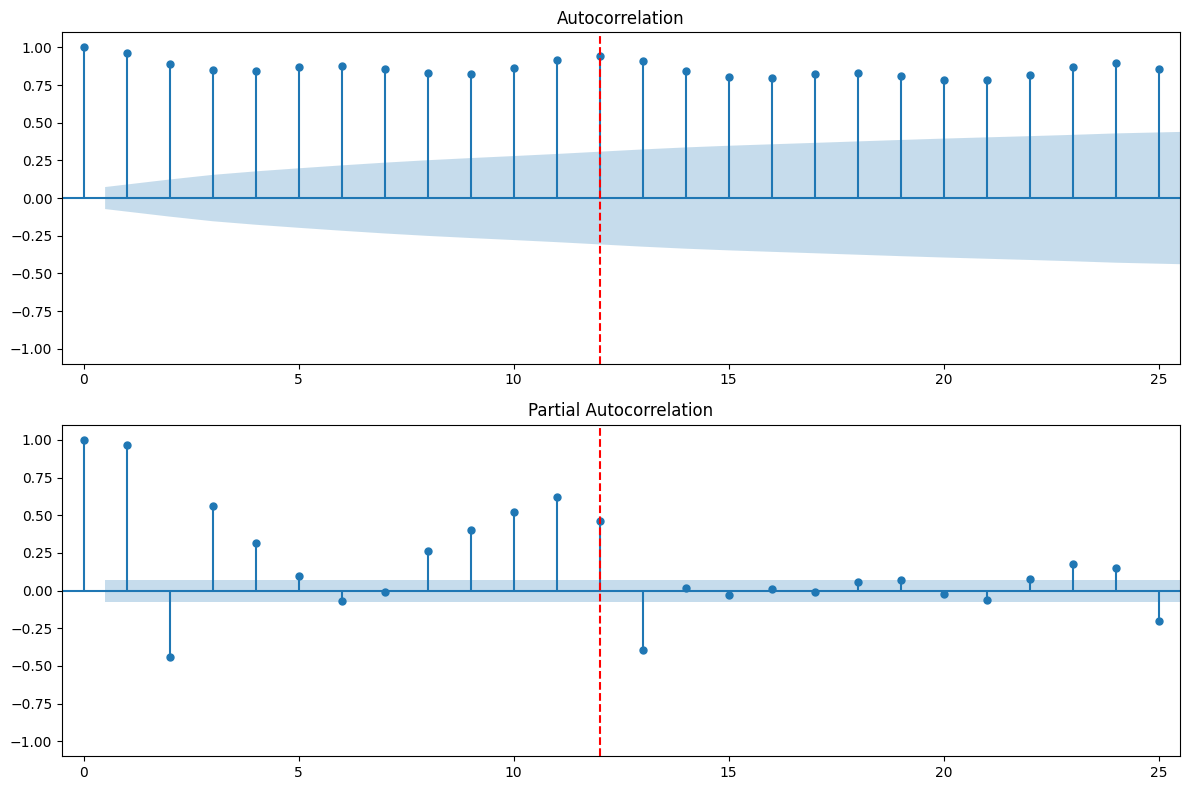

In [36]:
index = 100
dataset_splitted = split_by_categories(dataset_padded)

CAT_RUNNING = 2
series = dataset_splitted[CAT_RUNNING].iloc[index]
series = series[valid_periods.loc[series.name, 0]:valid_periods.loc[series.name, 1]]

print("Category C")
check_stationarity(series)
plot_acf_pacf(series, 25, 25, 12)

#### Category D

Category D
ADF Statistic: -2.6578510063084266
p-value: 0.0816201453194394
Critical Values:
	 1%: -3.44550760169756
	 5%: -2.868222645936761
	 10%: -2.5703296137102085
Non-stationary


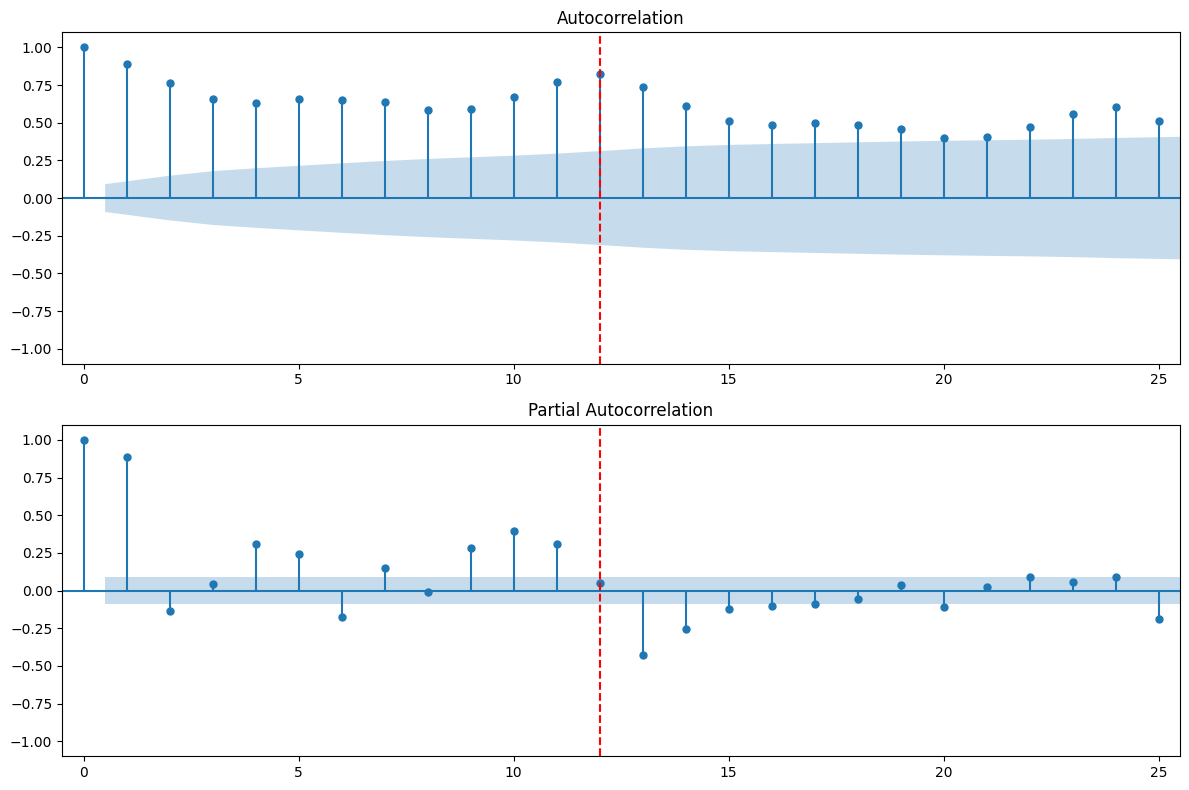

In [37]:
index = 0
dataset_splitted = split_by_categories(dataset_padded)

CAT_RUNNING = 3
series = dataset_splitted[CAT_RUNNING].iloc[index]
series = series[valid_periods.loc[series.name, 0]:valid_periods.loc[series.name, 1]]

print("Category D")
check_stationarity(series)
plot_acf_pacf(series, 25, 25, 12)

#### Category E

Category E
ADF Statistic: -1.4825393466442132
p-value: 0.5421305151961343
Critical Values:
	 1%: -3.4776006742422374
	 5%: -2.882265832283648
	 10%: -2.5778219289774156
Non-stationary


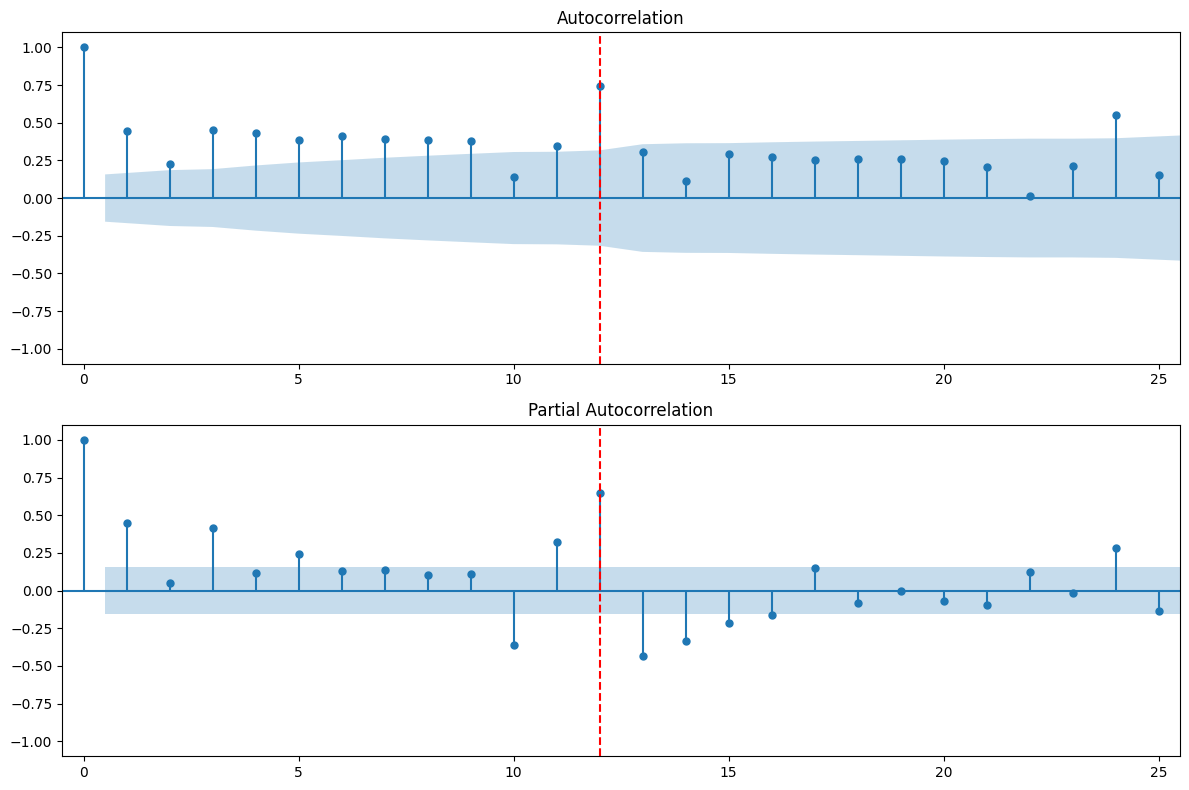

In [38]:
index = 200
dataset_splitted = split_by_categories(dataset_padded)

CAT_RUNNING = 4
series = dataset_splitted[CAT_RUNNING].iloc[index]
series = series[valid_periods.loc[series.name, 0]:valid_periods.loc[series.name, 1]]

print("Category E")
check_stationarity(series)
plot_acf_pacf(series, 25, 25, 12)

#### Category F

Category F
ADF Statistic: -0.31682328235476437
p-value: 0.9230876253451163
Critical Values:
	 1%: -3.497501033
	 5%: -2.89090644
	 10%: -2.5824349
Non-stationary


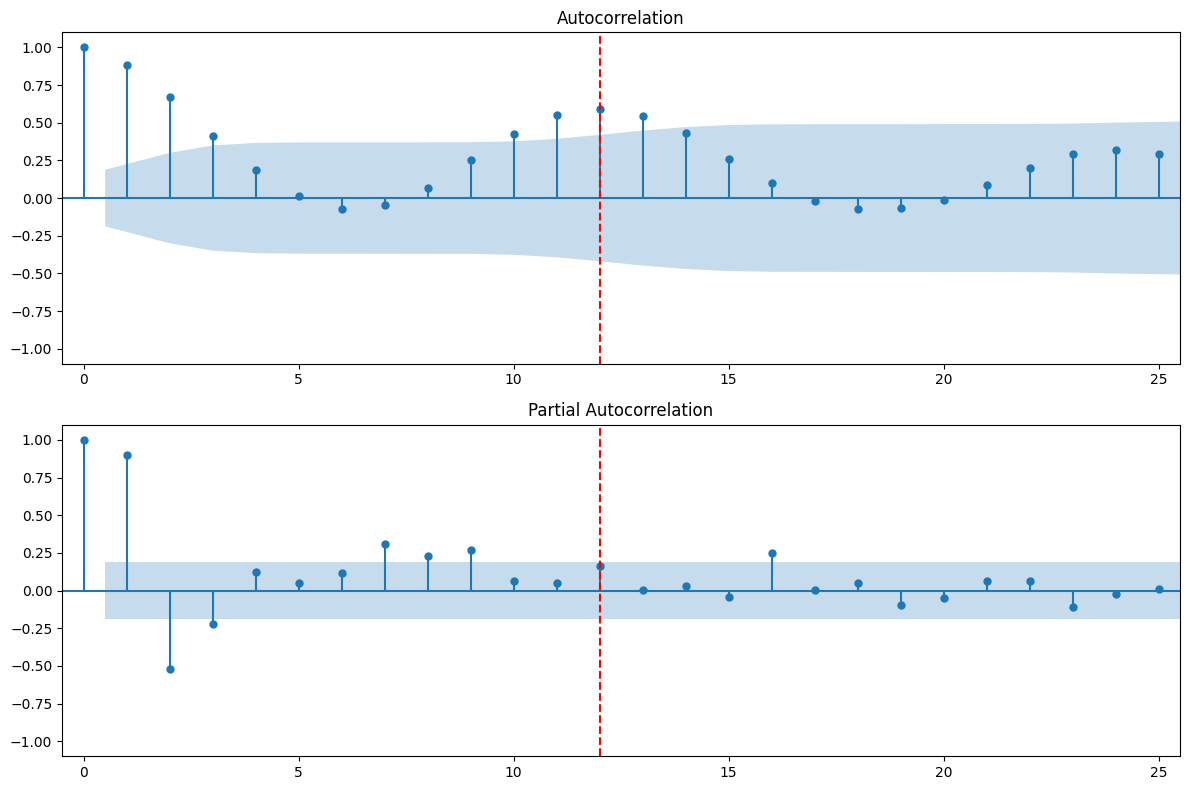

In [39]:
index = 20
dataset_splitted = split_by_categories(dataset_padded)

CAT_RUNNING = 5
series = dataset_splitted[CAT_RUNNING].iloc[index]
series = series[valid_periods.loc[series.name, 0]:valid_periods.loc[series.name, 1]]

print("Category F")
check_stationarity(series)
plot_acf_pacf(series, 25, 25, 12)

### Build sequences

In [40]:
def build_sequences(temp_dataset, window, stride, telescope) -> tuple[np.ndarray]:
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []

    for i in range(temp_dataset.shape[0]):
        series = temp_dataset.iloc[i]
        period = valid_periods.loc[series.name, 0], valid_periods.loc[series.name, 1]
        series = series[period[0]:period[1]]
        scaler, series = normalization(series)
        padding_check = len(series)%(window + telescope)

        if(padding_check != 0):
            # Compute padding length
            padding_len = (window + telescope) - padding_check
            padding = np.zeros(padding_len, dtype='float32')
            series = np.concatenate((padding, series))
            assert len(series)%(window + telescope) == 0

        for idx in np.arange(0, len(series)-window-telescope+1, stride):
            dataset.append(series[idx:idx+window])
            labels.append(series[idx+window:idx+window+telescope])
    return np.array(dataset), np.array(labels)

## Training

### Parameters

In [41]:
CAT_RUNNING = 0 # change category here: A=0, B=1, C=2, D=3, E=4, F=5

BATCH_SIZE = 16
EPOCHS = 200
LR = 1e-6

WINDOW = 200
STRIDE = 10
TELESCOPE = 18

INPUT_SHAPE = [WINDOW, 1]
OUTPUT_SHAPE = [TELESCOPE, 1]

# EarlyStopping patience
ES_PATIENCE = 25

# ReduceLROnPlateau patience
RLROP_PATIENCE = 15

CALLBACKS = [
    tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_loss", mode='min', patience=RLROP_PATIENCE, factor=0.1, min_lr=1e-8)
]

### Build Model

### CONV_LSTM

In [42]:
def build_CONV_LSTM_model(input_shape, output_shape, name="CONV_LSTM_model") -> tfk.Model:
    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name="input_layer")

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(
        tfkl.LSTM(64, return_sequences=True, name="lstm"),
        name="bidirectional_lstm"
    )(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding="same", activation="relu", name="conv")(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(
        output_shape[1], 3, padding="same", name="output_layer"
    )(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name="cropping")(output_layer)

    # Construct the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=name)

    # Compile the model with Mean Squared Error loss and AdamW optimizer
    model.compile(
        loss = tfk.losses.MeanSquaredError(),
        optimizer = tfk.optimizers.AdamW(learning_rate=LR),
    )

    return model

### TCN

In [43]:
def TCN_block(block_input, dilation_rate) -> tf.Tensor:
    output = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(block_input)
    output = tfkl.Conv1D(128, 3, dilation_rate=dilation_rate, padding='causal')(output)
    output = tfkl.BatchNormalization()(output)
    output = tfkl.Dropout(0.2)(output)
    output = tfkl.ReLU()(output)
    output = tfkl.Dense(1)(output)
    output = tfkl.Add()([block_input, output])
    return tfkl.ReLU()(output)

In [44]:
def build_TCN_model(input_shape, output_shape, name="TCN_Autoencoder_model") -> tfk.Model:
    block_input = tfkl.Input(shape=input_shape, name="input_layer")
    block1 = TCN_block(block_input, 1)
    block2 = TCN_block(block1, 2)
    block3 = TCN_block(block2, 4)
    block_output = TCN_block(block3, 8)

    # Calculate the size to crop from the output to match the output shape
    crop_size = block_output.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name="cropping")(block_output)

    model = tfk.Model(inputs=block_input, outputs=output_layer, name=name)

    # Compile the model with Mean Squared Error loss and AdamW optimizer
    model.compile(
        loss = tfk.losses.MeanSquaredError(),
        optimizer = tfk.optimizers.AdamW(learning_rate=LR),
    )
    return model

### Stacked LSTM sequence to sequence Autoencoder

In [45]:
# Sequence to Sequence Model with two encoder layers and two decoder layers
def build_Stacked_LSTM_seq2seq_Autoencoder_model(input_shape, output_shape, name="Stacked_LSTM_Autoencoder_model") -> tfk.Model:
    encoder_inputs = tfkl.Input(shape=input_shape, name="input_layer")
    encoder_l1 = tfkl.LSTM(512, return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tfkl.LSTM(512, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    decoder_inputs = tfkl.RepeatVector(output_shape[0])(encoder_outputs2[0])
    decoder_l1 = tfkl.LSTM(512, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
    decoder_l2 = tfkl.LSTM(512, return_sequences=True)(decoder_l1, initial_state = encoder_states2)
    decoder_outputs2 = tfkl.TimeDistributed(tfkl.Dense(1))(decoder_l2)

    model = tfk.Model(inputs=encoder_inputs, outputs=decoder_outputs2, name=name)

    # Compile the model with Mean Squared Error loss and AdamW optimizer
    model.compile(
        loss = tfk.losses.MeanSquaredError(),
        optimizer = tfk.optimizers.AdamW(learning_rate=LR),
    )

    return model

In [ ]:
model = build_TCN_model(INPUT_SHAPE, OUTPUT_SHAPE)
lengths = valid_periods[1] - valid_periods[0]
dataset_categories = split_by_categories(dataset_padded.loc[lengths[lengths > (WINDOW+TELESCOPE)].index])
X_train, y_train = build_sequences(dataset_categories[CAT_RUNNING], WINDOW, STRIDE, TELESCOPE)

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_split = 0.1,
    callbacks = CALLBACKS
).history

In [ ]:
# Save the model
model.save('model_cat_'+str(CAT_RUNNING))

In [ ]:
if PLATFORM == "Kaggle":
    os.chdir(r'/kaggle/working')
    !zip -r file.zip /kaggle/working

## Testing

In [ ]:
def inspect_prediction(X, y, pred, telescope=TELESCOPE, idx=None):
    if(idx == None):
        idx = np.random.randint(0, len(X))

    X = np.expand_dims(X, axis=2)
    y = np.expand_dims(y, axis=2)

    pred = np.concatenate([np.expand_dims(X[:,-1,:], axis=1), pred], axis=1)
    y = np.concatenate([np.expand_dims(X[:,-1,:], axis=1), y], axis=1)

    plotter(
        [
            [
                np.arange(len(X[0,:,0])),
                X[idx,:,:]
            ],
            [
                np.arange(len(X[0,:,0])-1, len(X[0,:,0])+telescope),
                y[idx,:,:]
            ],
            [
                np.arange(len(X[0,:,0])-1, len(X[0,:,0])+telescope),
                pred[idx,:,:]
            ]
        ],
        ["X", "y", "prediction"]
    )

In [ ]:
def predictions_Normalization(X) -> np.ndarray:
    X = np.array(X) 
    predictions = []
    
    for i in range(0, X.shape[0]):
        scaler, X_scaled = normalization(np.squeeze(X[i]))     
        tmp_predictions = model.predict(X_scaled[np.newaxis, :], verbose=0)
        predictions.append(np.squeeze(scaler.inverse_transform(np.squeeze(tmp_predictions, axis=0))))
        
    predictions = np.array(predictions)
    return predictions

In [ ]:
WINDOW = 200
length = valid_periods[1] - valid_periods[0]
df = dataset_categories[CAT_RUNNING].loc[length.loc[dataset_categories[CAT_RUNNING].index][length >= (WINDOW+TELESCOPE)].index]
X = np.array(df.iloc[-60:, -(WINDOW+TELESCOPE):-TELESCOPE])
y = np.array(df.iloc[-60:, -TELESCOPE:])

predictions = predictions_Normalization(X)
# predictions = model.predict(X)

mean_squared_error = []
mean_absolute_error = []

for i in range(0, X.shape[0]):
  # Calculate and print Mean Squared Error (MSE)
  mean_squared_error.append(tfk.metrics.mean_squared_error(y[i].flatten(), predictions[i].flatten()).numpy())
  # Calculate and print Mean Absolute Error (MAE)
  mean_absolute_error.append(tfk.metrics.mean_absolute_error(y[i].flatten(), predictions[i].flatten()).numpy())

print(f"Mean Squared Error: {np.mean(mean_squared_error)}")
print(f"Mean Absolute Error: {np.mean(mean_absolute_error)}")